# Sample Notebook for causalmodel

In [1]:
# create a notebook to showcase the causalmodel
import sys
sys.path.insert(0,'..')

from observational import Observational 

In [2]:
import numpy as np

tau = 10

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def get_data(N = 10000, k=2):
    X = np.random.multivariate_normal(np.zeros(k), np.diag(np.ones(k)), N)*0.1
    prob = sigmoid(X.dot(np.linspace(-1,1,k)))
    Z = np.zeros(N)
    unif = np.random.uniform(0,1,N)
    Z[unif < prob] = 1
    Y = tau*Z + X.dot(np.linspace(-1,1,k)) + np.random.normal(0,1,N)
    return Y, Z, X, prob

In [ ]:
from LearningModels import LogisticRegression
from LearningModels import OLS

Y, Z, X, prob = get_data()
po = Observational(Y, Z, X)
po.est_via_ipw(LogisticRegression).show()
po.est_via_aipw(OLS, LogisticRegression).show()
po.est_via_matching(10,20).show()
po.est_via_matching(10,20,bias_adj=True).show()

********************
average treatment effect: 10.00433657296125

standard error:           0.10398954692174561

p value:                  0.0

confidence interval:      (9.800517060994629, 10.208156084927872)
********************
average treatment effect: 10.003322095047476

standard error:           0.01982332805890847

p value:                  0.0

confidence interval:      (9.964468372052016, 10.042175818042937)
********************
average treatment effect: 10.005892555958642

standard error:           0.020125968174275283

p value:                  0.0

confidence interval:      (9.966445658337063, 10.04533945358022)


In [6]:
def simulation(n=2000):
    Z_e, Z_thm, SE, SE_BOUND = list(), list(), list(), list()
    for i in range(n):
        Y, Z, X, prob = get_data()
        po = PotentialOutcome(Y, Z, X)
        result = po.est_via_ipw(LogisticRegression)
        t = result.average_treatment_effect
        se = result.standard_error
        se_bound = np.sqrt(np.mean(1/prob + 1/(1-prob))/len(Z))
        Z_e.append((t-tau)/se)
        Z_thm.append((t-tau)/se_bound)
        SE.append(se)
        SE_BOUND.append(se_bound)
    return Z_e, Z_thm, SE, SE_BOUND

In [7]:
import matplotlib.pyplot as plt
from scipy.stats import norm

Z_e, Z_thm, SE, SE_BOUND = simulation()

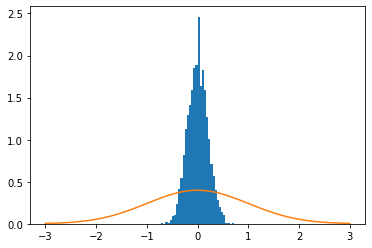

0.10230492885977441


In [8]:
_ = plt.hist(Z_e, density=True, bins='auto',range=(-3,3))
x = np.linspace(-3,3)
pdf = norm.pdf(x)
_ = plt.plot(x,pdf)
plt.show()
print(np.mean(SE))

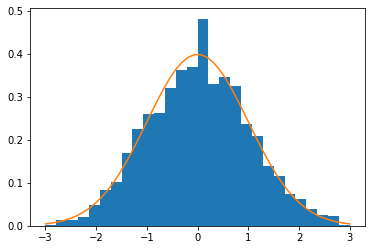

0.020050220175713448


In [9]:
_ = plt.hist(Z_thm, density=True, bins='auto',range=(-3,3))
x = np.linspace(-3,3)
pdf = norm.pdf(x)
_ = plt.plot(x,pdf)
plt.show()
print(np.mean(SE_BOUND))

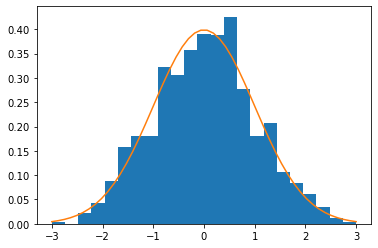

In [13]:
import matplotlib.pyplot as plt
from scipy.stats import norm

def simulation2(n=1000):
    Z, SE, TAU = list(), list(), list()
    for i in range(n):
        Y, T, X, prob = get_data(N=1000)
        po = PotentialOutcome(Y, T, X)
        result = po.est_via_aipw(OLS,LogisticRegression)
        z = result.z
        se = result.standard_error
        Z.append(z)
        SE.append(se)
        TAU.append(result.average_treatment_effect)
    return Z, SE, TAU

Z2, SE2, TAU2 = simulation2()
_ = plt.hist((np.array(TAU2) - tau)/np.sqrt(np.var(TAU2)), density=True, bins='auto', range=(-3,3))
x = np.linspace(-3,3)
pdf = norm.pdf(x)
_ = plt.plot(x,pdf)
plt.show()

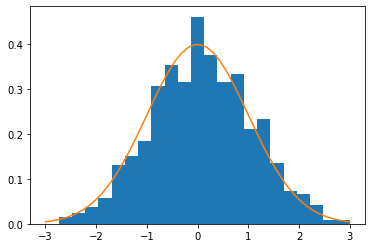

In [14]:
import matplotlib.pyplot as plt
from scipy.stats import norm

def simulation3(n=1000):
    Z, SE, TAU = list(), list(), list()
    for i in range(n):
        Y, T, X, prob = get_data(N=1000)
        po = PotentialOutcome(Y, T, X)
        result = po.est_via_matching(1,1,bias_adj=True)
        z = result.z
        se = result.standard_error
        Z.append(z)
        SE.append(se)
        TAU.append(result.average_treatment_effect)
    return Z, SE, TAU

Z3, SE3, TAU3 = simulation3()
_ = plt.hist((np.array(TAU3) - tau)/np.sqrt(np.var(TAU3)), density=True, bins='auto', range=(-3,3))
x = np.linspace(-3,3)
pdf = norm.pdf(x)
_ = plt.plot(x,pdf)
plt.show()

In [8]:
from causalinference import CausalModel
from causalinference.utils import random_data
import time

#Y, D, X = random_data()
Y, D, X, prob = get_data(k=5)
causal = CausalModel(Y, D, X)
t1 = time.time()
causal.est_via_matching(matches=1,bias_adj=True)
t2 = time.time()
print(t2-t1, causal.estimates)
po = Observational(Y, D, X)
t1 = time.time()
ret = po.est_via_matching(1,1,bias_adj=True)
t2 = time.time()
print(t2-t1)
ret.show()

4.641599893569946 
Treatment Effect Estimates: Matching

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE     10.002      0.032    311.408      0.000      9.939     10.065
           ATC     10.018      0.036    281.039      0.000      9.948     10.087
           ATT      9.987      0.036    280.814      0.000      9.917     10.057

6.44301176071167
********************
average treatment effect: 10.00138060041896

standard error:           0.022613957937897458

p value:                  0.0

confidence interval:      (9.957057242860682, 10.045703957977238)
